In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from pyspark.context import SparkContext, SparkConf
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession \
    .builder \
    .appName("netflix-recommendation-system") \
    .getOrCreate()

In [3]:
conf = SparkConf().setAppName("rdd basic").setMaster("local[12]")

In [4]:
keras_datasets_path = Path("C:/Users/bayra/Desktop/tez proje/Recommender_Deneme_withbigdata/Data").parents[0]

In [5]:
movielens_dir = keras_datasets_path / "C:/Users/bayra/Desktop/tez proje/Recommender_Deneme_withbigdata/Data/"

In [6]:
ratings_file = movielens_dir / "C:/Users/bayra/Desktop/tez proje/Recommender_Deneme_withbigdata/Data/ratings.csv"

In [7]:
df = pd.read_csv(ratings_file)

In [8]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 283228, Number of Movies: 53889, Min rating: 0.5, Max rating: 5.0


In [9]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 70% of the data and validating on 30%.
train_indices = int(0.7 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [10]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [11]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=2048,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
9487/9487 [==============================] - 1012s 106ms/step - loss: 1.0416 - val_loss: 1.4347
Epoch 2/5
9487/9487 [==============================] - 1061s 112ms/step - loss: 1.8670 - val_loss: 2.1711
Epoch 3/5
9487/9487 [==============================] - 1095s 115ms/step - loss: 2.5954 - val_loss: 2.9616
Epoch 4/5
9487/9487 [==============================] - 1116s 118ms/step - loss: 3.3075 - val_loss: 3.9070
Epoch 5/5
9487/9487 [==============================] - 1061s 112ms/step - loss: 3.9018 - val_loss: 4.6001


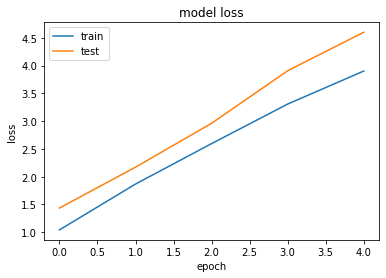

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [13]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 22040
Movies with high ratings from user
--------------------------------
My Left Foot (1989) : Drama
Harold and Maude (1971) : Comedy|Drama|Romance
Shall We Dance? (Shall We Dansu?) (1996) : Comedy|Drama|Romance
Gods and Monsters (1998) : Drama
My Son the Fanatic (1997) : Comedy|Drama|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Dead Man Walking (1995) : Crime|Drama
Seven (a.k.a. Se7en) (1995) : Mystery|Thriller
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Fugitive, The (1993) : Thriller
Killing, The (1956) : Crime|Film-Noir
400 Blows, The (Les quatre cents coups) (1959) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure|Fantasy
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy
Eternal Sunshine of the Spotless Mind (2004) : Drama|Romance|Sci-Fi
